## Acorn_2_Team_Project

팀 프로젝트
쓰레기 분류 모델 만들기

In [ ]:
# !pip install -q tf-nightly numpy matplotlib

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

from google.colab import drive

구글 드라이브 mount 하기

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


데이터 전처리
내 드라이브 내에 있는 이미지경로를 통해 train,test로 나누어 시작

In [ ]:
PATH = '/content/drive/MyDrive/gabi'
train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH, 'test')

LABELS = ['can', 'glass', 'paper', 'pet', 'plastic', 'vinyl']
BATCH_SIZE = 32
EPOCHS = 20
IMG_SIZE = (160, 160)

# train dataset 설정 - 학습
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='categorical')
# validation dataset 설정 - 검증
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  label_mode='categorical')

Found 11281 files belonging to 6 classes.
Found 5651 files belonging to 6 classes.


sample data 확인

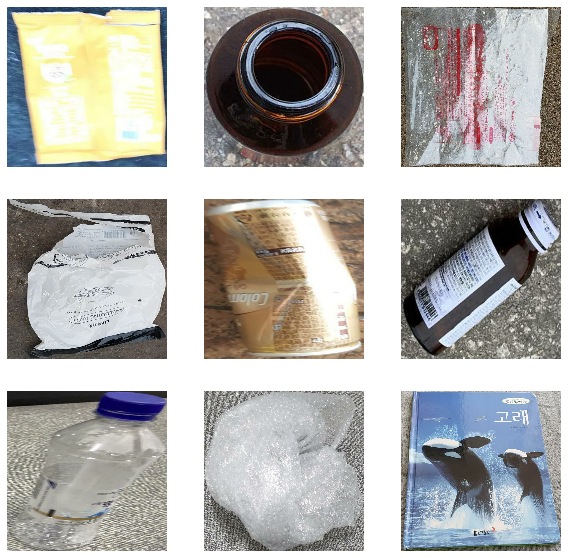

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

원본 데이터세트에는 테스트 세트가 포함되어 있지 않으므로 테스트 세트를 생성

tf.data.experimental.cardinality를 사용하여 검증 세트에서 사용할 수 있는 데이터 배치 수를 확인한 다음 그 중 20%를 테스트 세트로 이동

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 142
Number of test batches: 35


성능을 높이도록 데이터세트 구성하기

버퍼링된 prefetch를 사용하여 I/O 차단 없이 디스크에서 이미지를 로드

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

픽셀 값 재조정

잠시 후 기본 모델로 사용할 tf.keras.applications.MobileNetV2를 다운로드합니다. 이 모델은 [-1, 1]의 픽셀 값을 예상하지만 이 시점에서 이미지의 픽셀 값은 [0, 255]입니다. 크기를 재조정하려면 모델에 포함된 전처리 메서드를 사용하세요.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# 기본 모델 생성 (MobileNet V2 모델)

Google에서 개발한 MobileNet V2 모델로부터 기본 모델을 생성

* MobileNet V2 : MobileNet V2는 이전 모델인 MobileNet을 개선한 네트워크 입니다. 따라서 MobileNet과 동일하게 MobileNet V2는 임베디드 디바이스 또는 모바일 장치를 타겟으로 하는 단순한 구조의 경량화 네트워크를 설계하는데 이용됩니다.

* MobileNet V2는 MobileNet V1을 기반으로 두고 몇가지 개선점을 추가했습니다. MobileNet V1에서 사용하던 Depthwise-Separable Convolution을 주로 사용하고 width/resolution multiplyer를 사용해 정확도와 모델 크기를 trade-off하는 등 유사한 점이 많습니다.
하지만 단순히 Depthwise-Separable Convolution을 쌓은 구조의 MobileNet과는 달리 MobileNet v2에서는 Inverted Residual block이라는 구조를 이용해 네트워크를 구성한 차이점이 있습니다.

* 특징
* 1) Bottleneck Residual Block의 구조
MobileNet V2을 구성하는 Bottleneck residual block은 아래 표와 같이 3개의 Convolution layer로 구성됩니다.
이전의 Bottleneck 구조와 차이점은 입력된 feature map의 채널 수를 늘리는 expansion ratio라는 변수(위 표에서 t)가 사용되는 점 입니다. 이 expansion ratio를 활용해 입력 채널의 수를 조절합니다. expansion ratio는 5~10의 값일 때 좋은 성능을 보여주었다고 하며, 논문에서는 최종적으로 6을 사용합니다.

* 2) ReLU6 사용
또 다른 차이점은 ReLU대신 ReLU6를 사용하는 점 입니다.
ReLU는 입력값이 양수일 때 입력된 값을 그대로 반환하지만, ReLU6는 6보다 큰 값을 6으로 고정하여 반환합니다. ReLU6는 INT8이나 FP16연산과 같은 low-precision 연산에서 강건한(robustness) 특징을 갖기 때문에 사용되었다고 합니다.

* 3) Trade-off hyper parameters
MobileNet V1과 마찬가지로 MobileNet V2에서는 width multiplier와 해상도(resolution) 조정을 사용해 성능과 네트워크 크기를 trade-off 합니다.
Mobilenet과의 차이점은 width multiplier를 마지막 layer를 제외한 모든 layer에 적용한다는 것입니다.

참조 : https://gaussian37.github.io/dl-concept-mobilenet/


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


이 특징 추출기는 각 160x160x3 이미지를 5x5x1280 개의 특징 블록으로 변환

이미지 배치 예제에서 수행하는 작업을 확인

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


특징 추출

이 단계에서는 이전 단계에서 작성된 컨벌루션 베이스 모델을 동결하고 특징 추출기로 사용

위에 분류기를 추가하고 최상위 분류기를 훈련

컨볼루션 베이스 모델 고정

모델을 컴파일하고 훈련하기 전에 컨볼루션 기반을 고정하는 것이 중요.
동결(layer.trainable = False로 설정)은 주어진 레이어의 가중치가 훈련 중에 업데이트되는 것을 방지
MobileNet V2에는 많은 레이어가 있으므로 전체 모델의 trainable 플래그를 False로 설정하면 레이어가 모두 동결

In [ ]:
base_model.trainable = False

BatchNormalization 레이어에 대한 중요 참고 사항

많은 모델에는 tf.keras.layers.BatchNormalization 레이어가 포함되어 있습니다. 이 레이어는 특별한 경우이며 이 튜토리얼의 뒷부분에 나와 있는 것처럼 미세 조정의 맥락에서 주의를 기울여야 합니다.

layer.trainable = False를 설정하면 BatchNormalization 레이어가 추론 모드에서 실행되고 평균 및 분산 통계를 업데이트하지 않습니다.

미세 조정을 위해 BatchNormalization 레이어를 포함하는 모델을 동결 해제하면 기본 모델을 호출할 때 training = False를 전달하여 BatchNormalization 레이어를 추론 모드로 유지해야 합니다. 그렇지 않으면 훈련 불가능한 가중치에 적용된 업데이트로 인해 모델이 학습한 내용이 파괴됩니다.

In [ ]:
# 기본 모델 아키텍처를 살펴보자
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

분류 층을 맨 위에 추가하기

특성 블록에서 예측을 생성하기 위해 tf.keras.layers.GlobalAveragePooling2D 레이어를 사용하여 특성을 이미지당 하나의 1280-요소 벡터로 변환하여 5x5 공간 위치에 대한 평균을 구합니다.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


tf.keras.layers.Dense 레이어를 사용하여 특성을 이미지당 단일 예측으로 변환합니다. 이 예측은 logit또는 원시 예측 값으로 취급되므로 활성화 함수가 필요하지 않습니다. 양수는 클래스 1을 예측하고 음수는 클래스 0을 예측합니다.

In [ ]:
prediction_layer = tf.keras.layers.Dense(6, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


Keras Functional API를 사용하여 데이터 증강, 크기 조정, base_model 및 특성 추출기 레이어를 함께 연결하여 모델을 구축합니다. 모델에 BatchNormalization 레이어가 포함되어 있으므로 training=False 로 사용해야 합니다.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

* 모델 컴파일
학습하기 전에 모델을 컴파일합니다. 두 개의 클래스가 있으므로 모델이 선형 출력을 제공하므로 from_logits = True와 함께 이진 교차 엔트로피 손실을 사용합니다.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

MobileNet의 2.5M 개의 매개 변수는 고정되어 있지만 Dense 층에는 1.2K 개의 trainable 매개 변수가 있습니다. 이것들은 두 개의 tf.Variable 객체, 즉 가중치와 바이어스로 나뉩니다.

In [ ]:
len(model.trainable_variables)

2

모델 훈련
10 epochs만큼 훈련

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

142/142 [==============================] - 746s 4s/step - loss: 2.3898 - accuracy: 0.1496


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.39
initial accuracy: 0.15


모델 학습 시키기

In [ ]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/20
353/353 [==============================] - 2010s 6s/step - loss: 1.4603 - accuracy: 0.4497 - val_loss: 0.9045 - val_accuracy: 0.6886
Epoch 2/20
353/353 [==============================] - 55s 155ms/step - loss: 0.8446 - accuracy: 0.7007 - val_loss: 0.6955 - val_accuracy: 0.7619
Epoch 3/20
353/353 [==============================] - 92s 260ms/step - loss: 0.6945 - accuracy: 0.7545 - val_loss: 0.6109 - val_accuracy: 0.7919
Epoch 4/20
353/353 [==============================] - 53s 149ms/step - loss: 0.6140 - accuracy: 0.7843 - val_loss: 0.5637 - val_accuracy: 0.8067
Epoch 5/20
353/353 [==============================] - 53s 149ms/step - loss: 0.5623 - accuracy: 0.8047 - val_loss: 0.5359 - val_accuracy: 0.8133
Epoch 6/20
353/353 [==============================] - 53s 147ms/step - loss: 0.5256 - accuracy: 0.8170 - val_loss: 0.5101 - val_accuracy: 0.8208
Epoch 7/20
353/353 [==============================] - 54s 151ms/step - loss: 0.5029 - accuracy: 0.8236 - val_loss: 0.4927 - val_acc

FileNotFoundError: ignored

학습 곡선

MobileNet V2 기본 모델을 고정된 특징 추출기로 사용했을 때의 학습 및 검증 정확도 / 손실의 학습 곡선

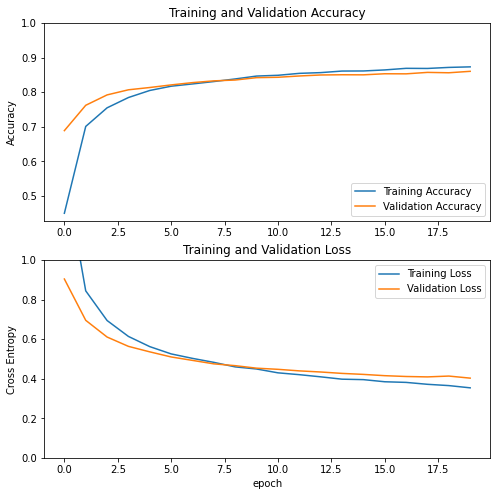

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

모델 저장하기

In [ ]:
model.save('recycle.h5')

평가 및 예측

마지막으로 test_dataset을 사용하여 새 데이터에 대한 모델의 성능을 확인

In [ ]:
loss_final, accuracy_final = model.evaluate(test_dataset)

35/35 [==============================] - 4s 104ms/step - loss: 0.3948 - accuracy: 0.8616


In [ ]:
print("Final loss: {:.2f}".format(loss_final))
print("Final accuracy: {:.2f}".format(accuracy_final))

Final loss: 0.39
Final accuracy: 0.86
